# 1. Set up the environment

In [1]:
! pip install setuptools
! python.exe -m pip install --upgrade pip

In [2]:
! pip install --upgrade moku

In [3]:
%pip install --q moku[neuralnetwork]

Note: you may need to restart the kernel to use updated packages.


In [4]:
import moku

In [5]:
import sys
print("Python version")
print(sys.version)

Python version
3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]


In [6]:
! mokucli list

Name                 Serial  HW     FW     IP                  
---------------------------------------------------------------


In [7]:
! pip install numpy ipykernel matplotlib tqdm scipy
! pip install torch

## 1.2 Set up the Python environment

In [8]:
import ast
import csv
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random

try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    print("If you're running in a Notebook like Google Colab, uncomment the first line in this cell and run it again")
    print("Otherwise install the moku library with neural network extensions using `pip install moku[neuralnetwork]`")
    raise

If the following command fails, make sure to download the utils_anomaly_detection file from the tutorial page and save it in the same folder as this notebook.

In [9]:
import utils_anomaly_detection

In [10]:
# set the seed for repeatability
seed = 42
np.random.seed(seed)

In [11]:
#quant_mod = michela_linn.LinnModel()
quant_mod = LinnModel()

# 2. Generate the training and testing datasets 
You can skip to the following section if you just want to load the data from file

In [12]:
# Define the input variables for the training dataset
n_samples = 5000 # Number of samples or frames in your dataset
amplitude_v= 1 # Waveform ampitude.
anomaly_p = 0.01  # value 0-1, where 0.01 means 1% of the frames will contain an anomaly
glitch_factor_v = 0.8 # amplitude of the glitch compared to the underlying normal waveform/
folder_path_value = "testing_dataset_ad/" # use "testing_dataset_ad/" to generate the testing dataset

In [13]:
signals, anomaly_indexes = utils_anomaly_detection.create_dataset_glitch(num_samples=n_samples, amplitude_value=amplitude_v, anomaly_percentage=anomaly_p , glitch_factor_value=glitch_factor_v, folder_path=folder_path_value)

50/5000 frames will peresent an anomaly
Folder 'testing_dataset_ad/' already exists.


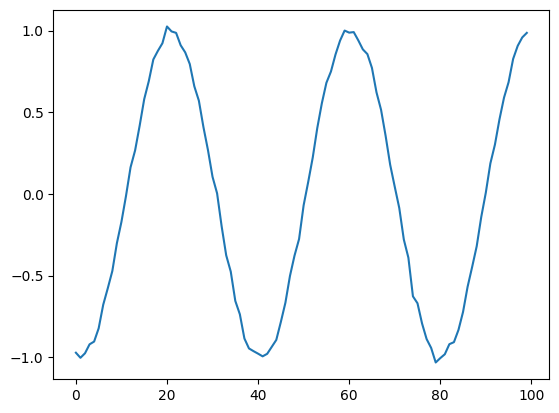

In [14]:
# You can plot any of the 5000 "frames"
frame_index = 0
plt.plot(signals[frame_index])

In [15]:
# To extract all the frames with a glitch, you can print the full list
print(anomaly_indexes)

[2151, 2023, 4475, 1967, 2662, 4499, 1482, 1054, 910, 4507, 1638, 3182, 1479, 207, 3361, 2098, 1693, 1416, 4545, 3473, 3124, 4728, 709, 3909, 3495, 3374, 4973, 3543, 1051, 3904, 3108, 484, 4096, 3282, 315, 3255, 3112, 394, 3350, 4313, 236, 846, 4191, 2064, 4683, 4305, 676, 130, 1977, 2876]


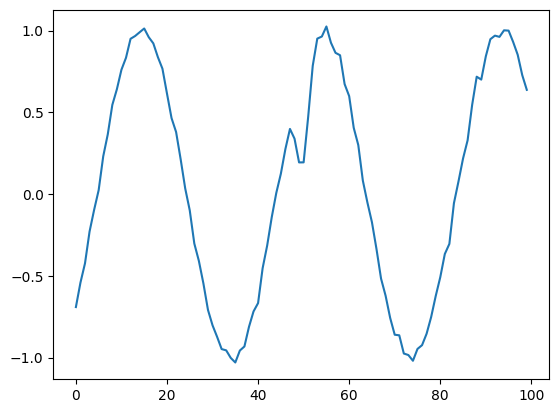

In [16]:
# To print any of the anomalous "frames"
frame_index = anomaly_indexes[1]
plt.plot(signals[frame_index])

Now you can repeat the same to generate the testing dataset

## 3. Load the training dataset from file
If you want to skip step 3, you can use the files containing the training and testing datasets provided in te tutorial page. The dataset contained 5000 "frames" of noisy sine waves. 25/5000 frames contain a glitch. Each frame consists of 250 datapoints.
If you executed step n. 3 make sure the folder_path below is pointing to the training dataset location created above.

Ensure the dataset folder belongs to the same folder as the running notebook or adjust the path accordinlgy

In [17]:
#folder_path = 'training_dataset_ad/' # Replace with tutorial_training_dataset if using the data from the tutorial
folder_path = 'tutorial_training_dataset/'
training_dataset, waveform_metadata_file, anomaly_metadata_file = utils_anomaly_detection.load_dataset(folder_path)

Files in the folder tutorial_training_dataset/ : ['anomaly_metadata.csv', 'data.csv']
Waveform metadata filename: data.csv
Anomaly metadata filename: anomaly_metadata.csv


### 3.1 Split the training dataset into training and validation sets.
80/20 split is used in this tutorial.

In [18]:
np.random.seed(seed)

train_size = int(0.8 * len(training_dataset))
val_size = len(training_dataset) - train_size

# Generate indices in order (same as torch.arange)
indices = np.arange(len(training_dataset))

# Split the indices into training and validation sets
train_indices = indices[:train_size]
val_indices = indices[train_size:]

found, message = utils_anomaly_detection.check_anomaly_from_metadata(anomaly_metadata_file, train_indices)
print(f"{message} in the training dataset")
print(f"Tot n. of frames in the training dataset: {train_size}")

print(len(training_dataset))



Found 40 anomalies in the training dataset
Tot n. of frames in the training dataset: 4000
5000


In [19]:
# Create train and validation datasets with the generated indices 
train_dataset = [training_dataset[i] for i in train_indices]
val_dataset = [training_dataset[i] for i in val_indices]



In [20]:
training_inputs = train_dataset
validation_inputs = val_dataset
full_dataset_inputs = training_dataset

## 4. Define the model and train

In [21]:
# Set up the early stopping - the below checks every 10 epochs 

early_stopping_config = {
    'patience': 10,   # Allow 10 epochs without improvement
    'restore_best_weights': True
}

In [22]:
# model definition for an autoencoder
frame_length = len(training_inputs[0])

# train the model
quant_mod.set_training_data(training_inputs=training_inputs, training_outputs=training_inputs)
model_definition = [(64, 'relu'), (32, 'relu'), (16, 'relu'), (frame_length, 'linear')]

# build the model
#quant_mod.construct_model(model_definition, show_summary=True)
quant_mod.construct_model(model_definition)

In [23]:
history = quant_mod.fit_model(epochs=100, es_config=early_stopping_config, validation_split=0.1)

Value for monitor missing. Using default:val_loss.
Value for restore missing. Using default:False.


Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3292 - val_loss: 0.0600
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0385 - val_loss: 0.0065
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 11/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/100
113/113 ━━━━━━━━━━━━━━━━━━━━

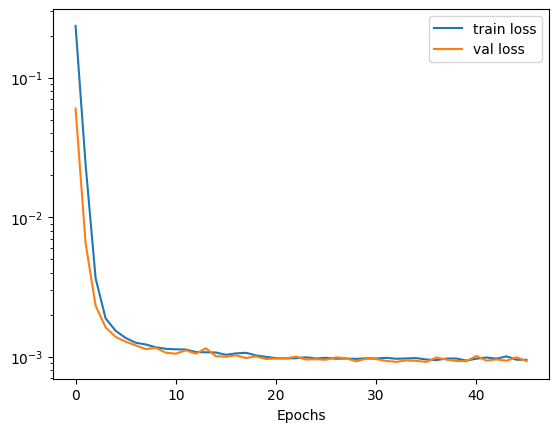

In [24]:
# plot the losses
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')
plt.show()

In [25]:
save_linn(quant_mod, input_channels=1, output_channels=1, file_name='AD_autoencoder_tutorial.linn')

Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 224 cycles


# 5. Testing the model - reconstruct the training dataset
This is used to see how well the model has learnt to reconstruct the data from the training dataset

**Reconstruction error** in the context of te autoencoders is the difference between the original input signal and the signal the model tries to reconstruct after encoding and decoding it. In our code, this would be the difference between training_inputs and reconstructions variables.

When the autoencoder is trained on normal data (that may contains sporadic anomalies like our training dataset), it learns the typical shape and patterns of the signal. So, when the AutoEncoder sees something unusual or unexpected (an anomaly), it struggles to reconstruct it accurately — resulting in a higher reconstruction error. 

By looking at where this error is large, we can spot potential anomalies that deviate from the learned normal behavior.

In [26]:
reconstructions = []
reconstructions = quant_mod.predict(full_dataset_inputs)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


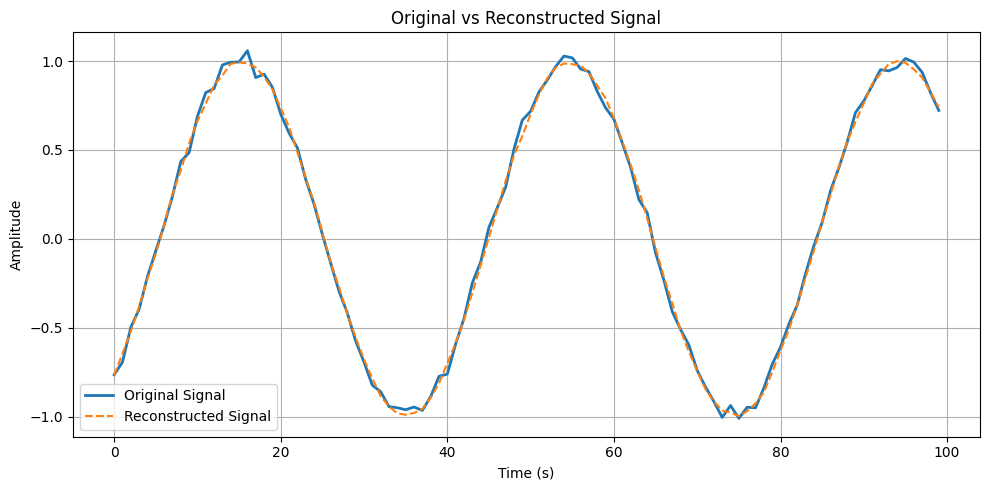

In [27]:
frame_id = 0

# Plotting both signals
plt.figure(figsize=(10, 5))
plt.plot(full_dataset_inputs[frame_id], label='Original Signal', linewidth=2)
plt.plot(reconstructions[frame_id], label='Reconstructed Signal', linestyle='--')
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# Extract the index of the frames with an anomaly from the testing metadata

frame_anomaly_training_dataset = []
anomaly_metadata_file = "tutorial_training_dataset/anomaly_metadata.csv"   # Change here the location to the anomaly metadata of your training dataset if different

with open(anomaly_metadata_file, mode="r") as file:

        
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
            
        try:
            frame_anomaly_training_dataset.append(ast.literal_eval(row[0]))

        except Exception as e:
            print(f"Error processing row: {row}. Error: {e}")
            break


In [29]:

anomaly_error, normal_error, values_error = utils_anomaly_detection.calculate_reconstruction_error_by_class_focal(full_dataset_inputs, reconstructions, frame_anomaly_training_dataset)


Now let's plot the error distribution for the two clases: frames with an anomaly and "normal" frames.

We are expecting to see a higher error in the frames with anomalies

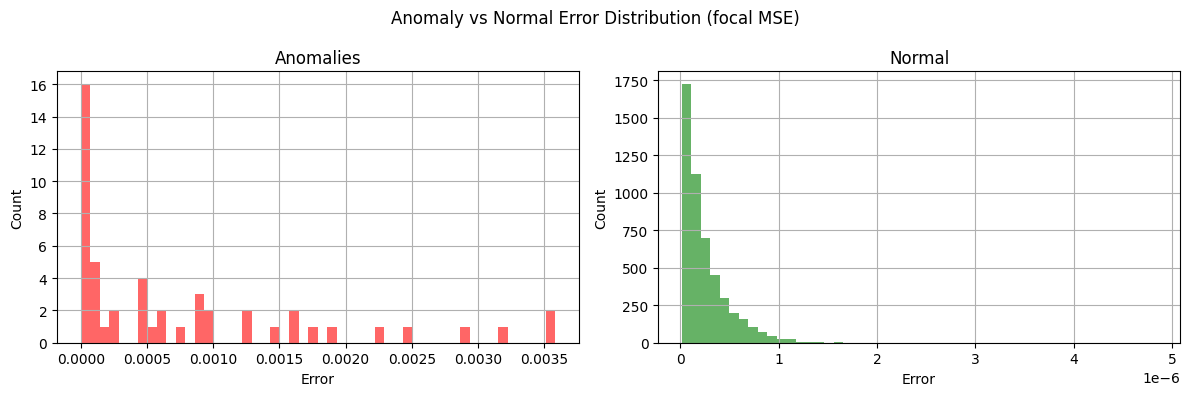

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Removed sharey=True

axs[0].hist(anomaly_error, bins=50, alpha=0.6, color='r')
axs[0].set_title('Anomalies')
axs[0].set_xlabel('Error')
axs[0].set_ylabel('Count')
axs[0].grid(True)

axs[1].hist(normal_error, bins=50, alpha=0.6, color='g')
axs[1].set_title('Normal')
axs[1].set_xlabel('Error')
axs[1].set_ylabel('Count')
axs[1].grid(True)

plt.suptitle('Anomaly vs Normal Error Distribution (focal MSE)')
plt.tight_layout()
plt.show()


There are many ways to set the error threshold for distinguishing between anomalous and normal frames. 

In this tutorial, we will use the percentile function applied to the training dataset to determine the threshold. 

However, we encourage you to experiment with different threshold values and observe how the resulting confusion matrix changes in the code below. This can provide valuable insights into the trade-off between precision and recall in your anomaly detection model.

For this tutorial, we will use the **96th percentile** of the training reconstruction errors as the threshold. This means that 96% of the training error values fall below this threshold, and only the top 4% are considered potentially anomalous. By setting the threshold this way, we aim to flag frames with unusually high reconstruction errors while minimizing false positives on normal data.

In [31]:
threshold = np.percentile(values_error, 99)  # Mark top 5% as anomalies
print('Threshold based on the 99 percentile of the training dataset:', threshold)

Threshold based on the 99 percentile of the training dataset: 2.232953519489302e-06


## 6. Test the model with unseen (new) data - testing dataset

In [32]:
# Load the testing dataset
folder_path_test = 'testing_dataset_ad/'
testing_dataset, waveform_metadata_file_test, anomaly_metadata_file_test = utils_anomaly_detection.load_dataset(folder_path_test)
testing_inputs = testing_dataset


Files in the folder testing_dataset_ad/ : ['anomaly_metadata.csv', 'data.csv']
Waveform metadata filename: data.csv
Anomaly metadata filename: anomaly_metadata.csv


In [33]:
# Extract the index of the frames with an anomaly from the testing metadata

frame_anomaly_test = []

with open(anomaly_metadata_file_test, mode="r") as file:

        
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
            
        try:
            frame_anomaly_test.append(ast.literal_eval(row[0]))

        except Exception as e:
            print(f"Error processing row: {row}. Error: {e}")
            break


In [34]:
reconstructions_test = []
reconstructions_test = quant_mod.predict(testing_inputs)

anomaly_error_test, normal_error_test, values_error_test = utils_anomaly_detection.calculate_reconstruction_error_by_class_focal(testing_inputs, reconstructions_test, frame_anomaly_test)
print(values_error_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[np.float64(2.8976871724428787e-08), np.float64(3.0140692616742995e-07), np.float64(3.711596448440424e-07), np.float64(4.667016129464085e-08), np.float64(1.745016615921771e-07), np.float64(1.0829187127146657e-07), np.float64(3.940733644856693e-07), np.float64(4.2272901783012004e-07), np.float64(1.3658548167767398e-07), np.float64(3.414248810264082e-08), np.float64(4.567710642939762e-08), np.float64(5.015805097761856e-07), np.float64(9.370226958474279e-08), np.float64(6.599055892599482e-08), np.float64(1.0696948045436477e-07), np.float64(1.0748677995796717e-07), np.float64(1.4831858276211417e-07), np.float64(2.211336828147695e-07), np.float64(1.3304793968000584e-07), np.float64(1.2635986050462453e-07), np.float64(7.618803350112313e-07), np.float64(4.634935774102865e-07), np.float64(8.526501176760653e-08), np.float64(9.160196233201424e-08), np.float64(3.6284984774646086e-08), np.float64(1.9346222050316088e-07), np.float64(6.145214527612718e-08), n

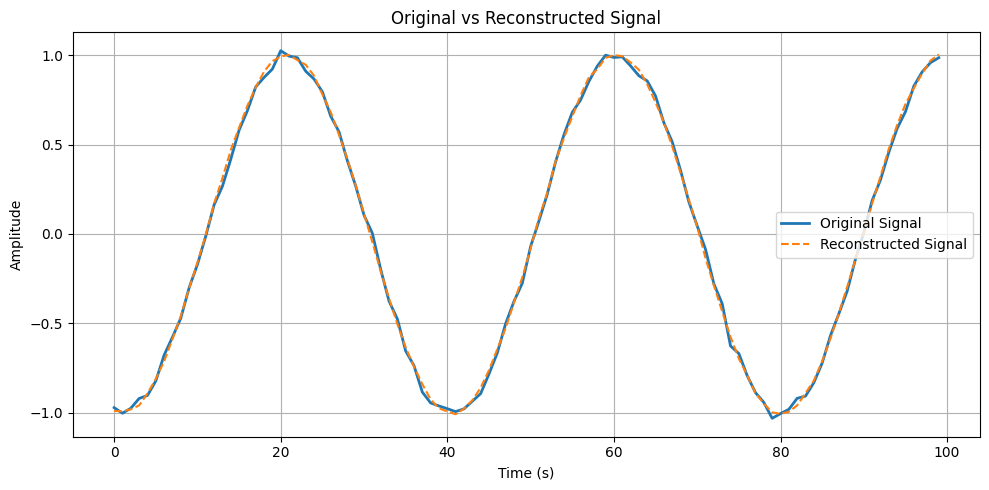

In [35]:
frame_id = 0

# Plotting both signals
plt.figure(figsize=(10, 5))
plt.plot(testing_inputs[frame_id], label='Original Signal', linewidth=2)
plt.plot(reconstructions_test[frame_id], label='Reconstructed Signal', linestyle='--')
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
values_error_per_frame_test = np.array(values_error_test)
predicted_labels_test = (values_error_per_frame_test > threshold).astype(int)  # 1 = anomaly, 0 = normal

We have now generated the list of values predicted_labels which flags all the anomalous frames with 1. 

In [37]:
true_labels_test = np.zeros(len(values_error_test), dtype=int)

count_anomaly = 0
for idx, label in enumerate(true_labels_test):
    if idx in frame_anomaly_test:
        true_labels_test[idx] = 1
        count_anomaly += 1
    
        
print(count_anomaly)
print(len(true_labels_test))
        

50
5000


Let's re-generate the focal MSE error distribution for the training dataset. We should expect a similar distribution to the training dataset, with higher error values on frames with anomaly. 

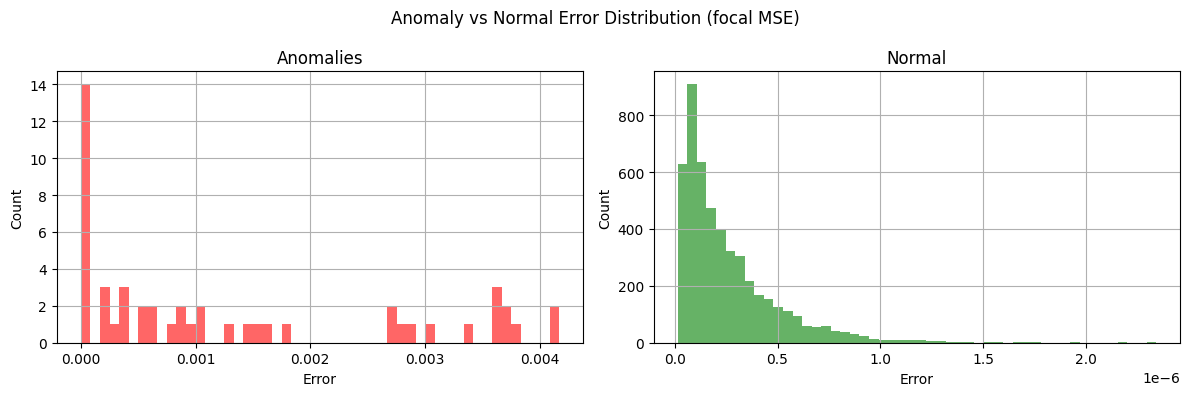

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Removed sharey=True

axs[0].hist(anomaly_error_test, bins=50, alpha=0.6, color='r')
axs[0].set_title('Anomalies')
axs[0].set_xlabel('Error')
axs[0].set_ylabel('Count')
axs[0].grid(True)

axs[1].hist(normal_error_test, bins=50, alpha=0.6, color='g')
axs[1].set_title('Normal')
axs[1].set_xlabel('Error')
axs[1].set_ylabel('Count')
axs[1].grid(True)

plt.suptitle('Anomaly vs Normal Error Distribution (focal MSE)')
plt.tight_layout()
plt.show()


### 6.1 Confusion matrix and f1 score

The **confusion matrix** is a useful tool for evaluating the performance of your binary model (does this frame contain an anomaly>). It summarizes how well the model distinguishes between normal and anomalous frames by showing four key outcomes: true positives (correctly identified anomalies), false positives (normal frames incorrectly flagged as anomalies), true negatives (correctly identified normal frames), and false negatives (missed anomalies). This breakdown helps you understand the trade-offs between sensitivity and specificity, especially important when dealing with noisy data where distinguishing true anomalies from random fluctuations can be challenging.

In this tutorial we are building an anomaly detection system based on imbalanced datasets. The training dataset is considered to be unbalanced because only around 1% of the data contains anomalies.

For this type of dataset, the **F1 score** is a valuable metric for evaluating model performance. Unlike accuracy, which can be misleading when normal data dominates, the F1 score balances precision (how many detected anomalies are actually correct) and recall (how many actual anomalies were detected). It is particularly useful when false negatives (missed anomalies) are costly, and you want to ensure that the model is both sensitive to rare events and not overwhelmed by false alarms. A high F1 score indicates a good balance between detecting anomalies and minimizing false positives in noisy, skewed datasets.

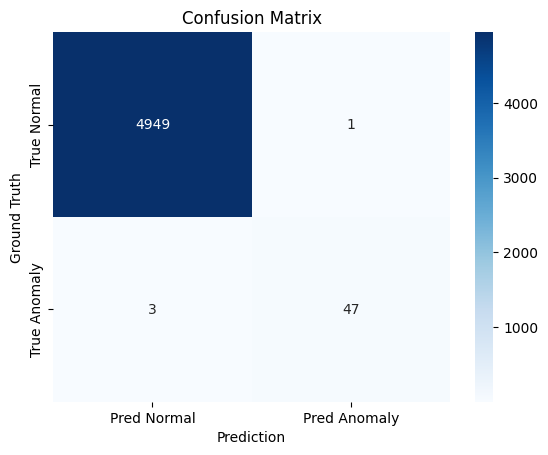

F1-score (Anomaly): 0.9592


In [39]:
# Extract the confusion matrix and f1 score

cm = confusion_matrix(true_labels_test, predicted_labels_test)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred Normal", "Pred Anomaly"],
            yticklabels=["True Normal", "True Anomaly"])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(true_labels_test, predicted_labels_test, target_names=["Normal", "Anomaly"], output_dict=True)
f1_anomaly = report["Anomaly"]["f1-score"]

print(f"F1-score (Anomaly): {f1_anomaly:.4f}")


Let's explore how different threshold values impact the F1 score and identify the optimal threshold for our anomaly detection task. To do this, we will evaluate a range of thresholds based on the reconstruction errors, considering all possible values between the 70th and 99th percentiles of the training dataset. 

In [40]:
p_75 = np.percentile(values_error, 75) 
p_999 = np.percentile(values_error, 99.9) 
print(p_75, p_999)

3.447607306569344e-07 0.0022295121725346987


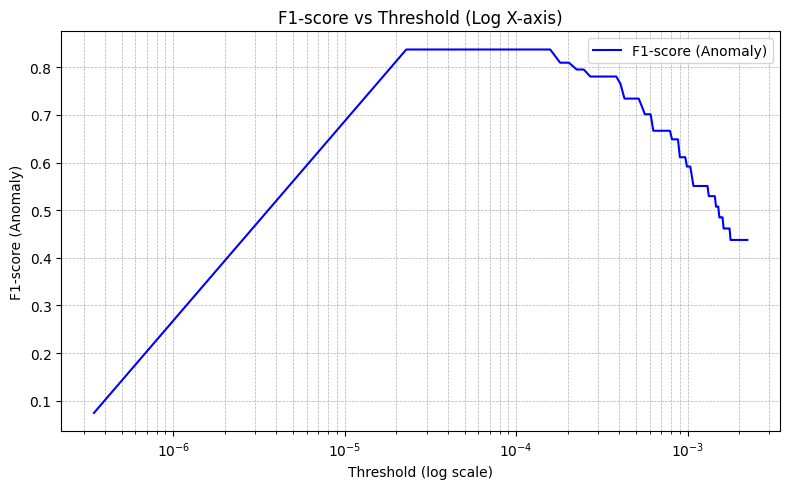

Best F1-score: 0.8372 at threshold: 2.2861603274132103e-05


In [ ]:
# Generate a range of thresholds 
thresholds = np.linspace(p_75, p_999, num=100)

f1_scores = []

# Compute F1-score for each threshold
for thresh in thresholds:
    predicted_labels = (values_error_per_frame_test > thresh).astype(int)
    report = classification_report(true_labels_test, predicted_labels, target_names=["Normal", "Anomaly"], output_dict=True)
    f1_anomaly = report["Anomaly"]["f1-score"]
    f1_scores.append(f1_anomaly)
f1_scores = np.array(f1_scores)

# Find threshold that gives the highest F1-score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

# Plot with log-scaled x-axis
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label="F1-score (Anomaly)", color="blue")
plt.xscale('log')  # <-- LOG SCALE for threshold axis
plt.xlabel("Threshold (log scale)")
plt.ylabel("F1-score (Anomaly)")
plt.title("F1-score vs Threshold (Log X-axis)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print(f"Best F1-score: {best_f1:.4f} at threshold: {best_threshold}")
